In [19]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
batch_size_train = 64
batch_size_test = 1024

Download the dataset directly from torchvision's datasets.

In [17]:
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In PyTorch we use dataloaders that we create with de dataset from torchvision

In [16]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size_train,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size_test,
    shuffle=True
)
len(train_loader)

938

We plot to check the dataloader

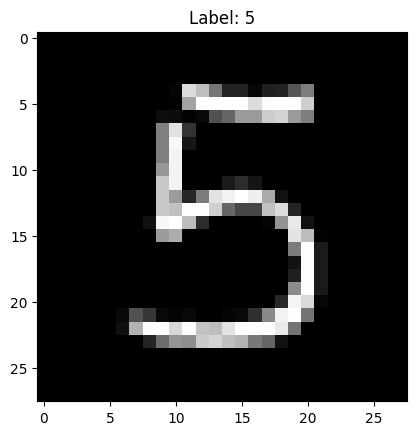

In [13]:
import matplotlib.pyplot as plt

_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0][0]
plt.imshow(sample, cmap='gray', interpolation='none')
plt.title(f'Label: {labels[0]}')
plt.show()

## Building our CNN model

In [20]:
class CNN(nn.Module):
    def __init__(self):
      super(CNN, self).__init__()
      self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
      self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
      self.conv2_drop = nn.Dropout2d()
      self.fc1 = nn.Linear(320, 50)
      self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
      x = self.conv1(x)
      x = F.max_pool2d(x, 2)
      x = F.relu(x)
      x = self.conv2(x)
      x = self.conv2_drop(x)
      x = F.max_pool2d(x, 2)
      x = F.relu(x)
      x = x.view(-1, 320)
      x = self.fc1(x)
      x = F.relu(x)
      x = F.dropout(x, training=self.training)
      x = self.fc2(x)
      return F.log_softmax(x)

Create model and optimizer

In [22]:
learning_rate = 0.01
momentum = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [27]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


<ipython-input-20-275dc8ebefa6>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [24]:
from tqdm import tqdm_notebook as tqdm

def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item() * data.size(0) / (counter * train_loader.batch_size)))

In [25]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [26]:
num_epoch = 3
for epoch in range(1, num_epoch + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

<ipython-input-24-b36c1d4a21d0>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/938 [00:00<?, ?it/s]

<ipython-input-20-275dc8ebefa6>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Average loss: 0.2998, Accuracy: 9163/10000 (92%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1725, Accuracy: 9466/10000 (95%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1319, Accuracy: 9582/10000 (96%)

